# Analyse de données des requêtes
Requêtes semaine 1, 2 et 3

In [5]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pour l'analyse unidimensionnelle et multidimensionnelle : 
from math import sqrt, log
from pandas.plotting import scatter_matrix
from pyensae.graphhelper import Corrplot
from statsmodels.graphics.mosaicplot import mosaic

# pour la Factor-Analysis-of-Mixed-Data (FAMD) : 
from light_famd import FAMD
from sklearn.preprocessing import scale

#clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
#from scipy.cluster.hierarchy import dendrogram

In [6]:
PATH_PROJECT = '/home/julie/Documents/cours/5A/IAF/defi_IA'
PATH_CODE = os.path.join(PATH_PROJECT,'code')
PATH_DATA = os.path.join(PATH_PROJECT,'data')
os.chdir(os.path.join(PATH_CODE,'utilities'))

from data_loading import main_load_data

# Chargement des données 

Remarque : La ligne suivant permet de faire le chargement des données de requêtes dans lesquelles on a déjà ajouté les informations complémentaires des hotels (group, brand...). 

Les données qualitatives sont séparées en deux listes (var\_quali et var\_quali\_to\_encode) mais dans un premier temps nous les traiteront comme un seul groupe. 

In [8]:
data,Y,var_quant,var_quali,var_quali_to_encode = main_load_data()

In [9]:
data

,avatar_id,city,date,language,mobile,hotel_id,stock,group,brand,parking,pool,children_policy
0,134838,copenhagen,13,german,0,153,9,Yin Yang,Royal Lotus,1,1,2
1,134838,copenhagen,13,german,0,251,4,Independant,Independant,0,0,0
2,134838,copenhagen,13,german,0,58,10,Yin Yang,Royal Lotus,1,0,2
3,134838,copenhagen,13,german,0,688,0,Independant,Independant,0,0,1
4,134838,copenhagen,13,german,0,720,15,Chillton Worldwide,Chill Garden Inn,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
531964,30026,rome,26,hungarian,1,714,7,Accar Hotels,Ibas,0,0,0
531965,30026,rome,26,hungarian,1,471,74,Yin Yang,Royal Lotus,1,0,0
531966,30026,rome,26,hungarian,1,728,53,Accar Hotels,Safitel,0,1,0
531967,30026,rome,26,hungarian,1,213,20,Independant,Independant,0,1,0


In [12]:
print("variable quantitatives : ", var_quant)
print("variable var_qualitatives : ", np.r_[var_quali,var_quali_to_encode])

variable quantitatives :  ['date', 'stock']
variable var_qualitatives :  ['mobile' 'parking' 'pool' 'children_policy' 'city' 'hotel_id' 'language'
 'group' 'brand']


# Transformer les données avec leur type

On passe les variables qualitatives en categorical. 

La colonne avatar\_id n'est pas traitée ici car nous la considérons comme un label. Elle ne sera donc considérée ni comme qualitative, ni comme quantitative et sera même supprimée à la fin de la mise en forme des données juste avant de faire entrer les données dans nos modèles. 

In [11]:
# Transform the dataset with the correct types : 
for var in var_quali :
    data[var]=pd.Categorical(data[var],ordered=False)
    
for var in var_quali_to_encode :
    data[var]=pd.Categorical(data[var],ordered=False)

data.dtypes

avatar_id             int64
city               category
date                  int64
language           category
mobile             category
hotel_id           category
stock                 int64
group              category
brand              category
parking            category
pool               category
children_policy    category
dtype: object

In [14]:
data[var_quant].describe()

,date,stock
count,531969.000000,531969.000000
mean,21.874703,43.955620
std,12.585859,50.911097
min,0.000000,0.000000
25%,11.000000,6.000000
50%,22.000000,25.000000
75%,33.000000,64.000000
max,43.000000,269.000000


# Exploration unidimensionnelle

## variables quantitatives et output 

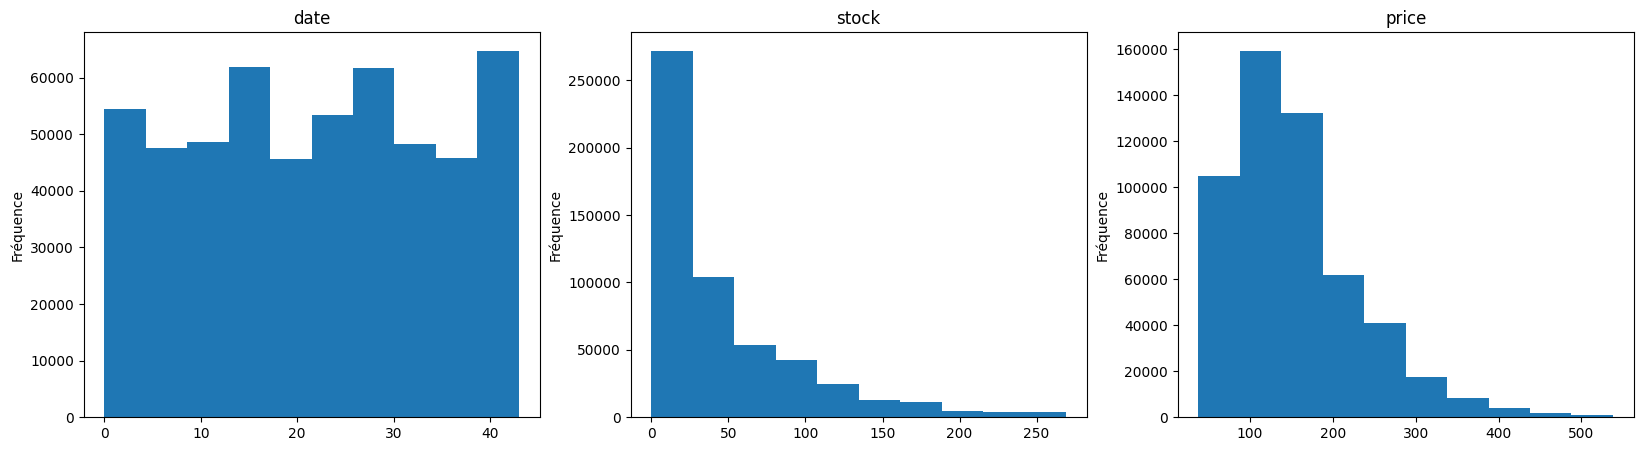

In [20]:
fig = plt.figure(figsize=(20, 5))

# variables qualitatives :
for i in range(0,len(var_quant)):
    plt.subplot(1, 3, i+1)
    plt.hist(data[var_quant[i]])
    plt.title(var_quant[i])
    plt.ylabel('Fréquence')

# output :
plt.subplot(1, 3, i+2)
plt.hist(Y)
plt.title('price')
plt.ylabel('Fréquence')

plt.show()
plt.close()

Commentaires : 
- price et stock suivent une distribution exponentielle => on va donc pouvoir leur appliquer une transformation **log** pour les recentrer. Le problème c'est que stock a une masse en zero, donc on va plutôt lui appliquer du sqrt.
- date a une répartition assez uniforme de 0 à 44 => bon point pour la manière donc on a fait les requêtes

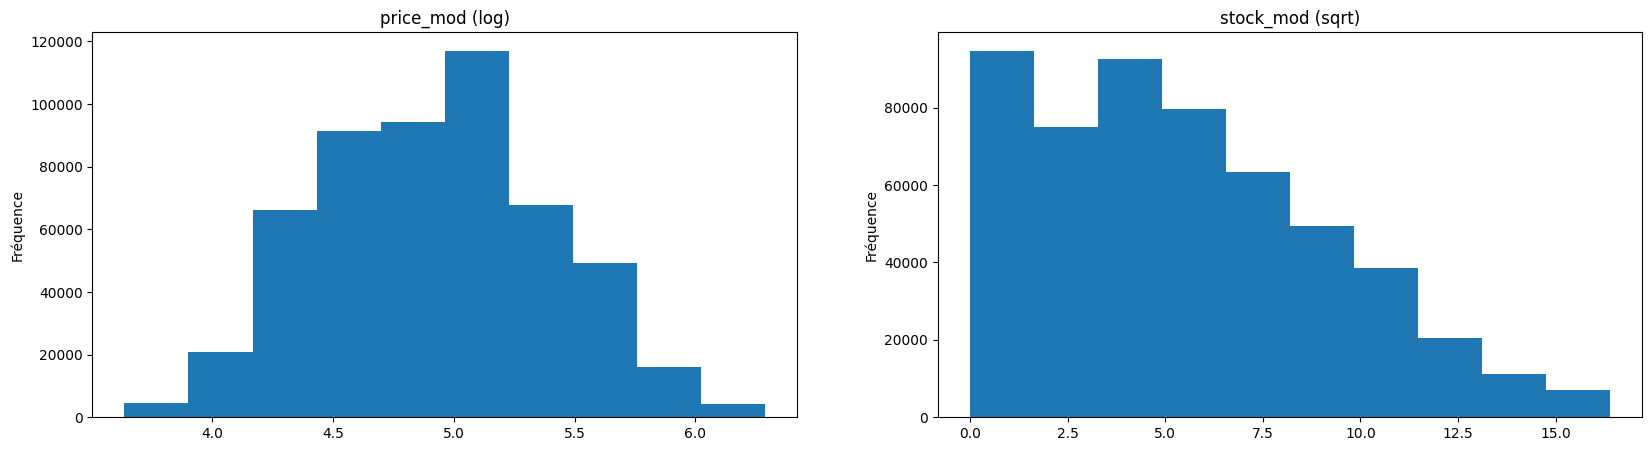

In [27]:
# transformation : 
Y_mod=np.log(Y)
data["stock_mod"]=data["stock"].map(lambda x: sqrt(x))

# on vérifie l'aspect de la nouvelle distribution : 
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(Y_mod)
plt.title("price_mod (log)")
plt.ylabel('Fréquence')
plt.subplot(1, 2, 2)
plt.hist(data["stock_mod"])
plt.title("stock_mod (sqrt)")
plt.ylabel('Fréquence')
plt.show()
plt.close()

In [28]:
data_mod = data.drop(["stock"],axis=1)
#data_mod.to_csv(PATH+"requetes_total_mod.csv",index=False)
var_quant = ["date","stock_mod"]

## Variables qualitatives

Interprétation des graphiques : 

Le premier set de pie charts concerne les variables qualitatives qui ont deux ou trois modalités. 
- La répartition mobile/pc est à peu près à 50/50. 
- Un peu plus de la moitié des hotels n'ont pas de parking.
- La majorité (83%) des hotels n'ont pas de piscine.
- Children_policy = 2 si l’hôtel interdit les enfants de moins de 18 ou 21 ans, 1 si l’hôtel interdit les enfants de moins de 12 ans, 0 s’il autorise les enfants sans restrictions. On remarque que 95% des hotels n'interdisent pas les enfants. 

Le deuxième set de pie charts concerne les variables qualitatives qui ont davantage de modalités :
- Les pie charts concernant la ville et la langue nous permettent de vérifier quelle répartition nous avons obtenu avec la stratégie de requête que nous avons implémenté. Sur les langues la répartition est assez uniforme, chaque langue représente 3 à 4% du dataset. Sur les villes on observe un peu plus de disparités, sofia et valetta ne représentent que 5% chacune, tandis que APris par exemple représente près de 17%. Les capitales les plus grosses (paris, amsterdam, copenhague, rome) sont celles qui sont le plus requêtées. 
- Le pie chat concernant les hotel_id est illisible et inutile car la variable à trop de modalité. Il faurda trouver une manière intelligente de la coder. Un one-hot-encoding résulterait en 1000 colonnes dans le jeu de données pour cette unique variable. 
- Les pie charts concernant le groupe et la marque nous permettent d'en savoir plus sur les caractéristiques des hotels tirés. On remarque une proportion conséquante d'hotels indépendants. 

**Les variables qualitatives du deuxième groupe seront transformées avec du target encoding pour éviter d'avoir trop de modalités.**

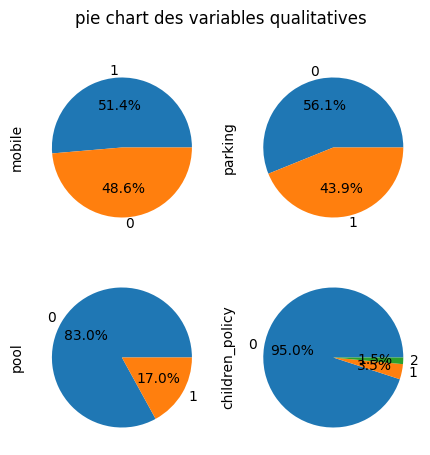

In [38]:
fig = plt.figure(figsize=(5, 5))
i = 1
for var in var_quali : 
    plt.subplot(2, 2, i)
    data_mod[var].value_counts().plot.pie(subplots=True, title="pie chart des variables qualitatives", autopct='%1.1f%%')
    i+=1


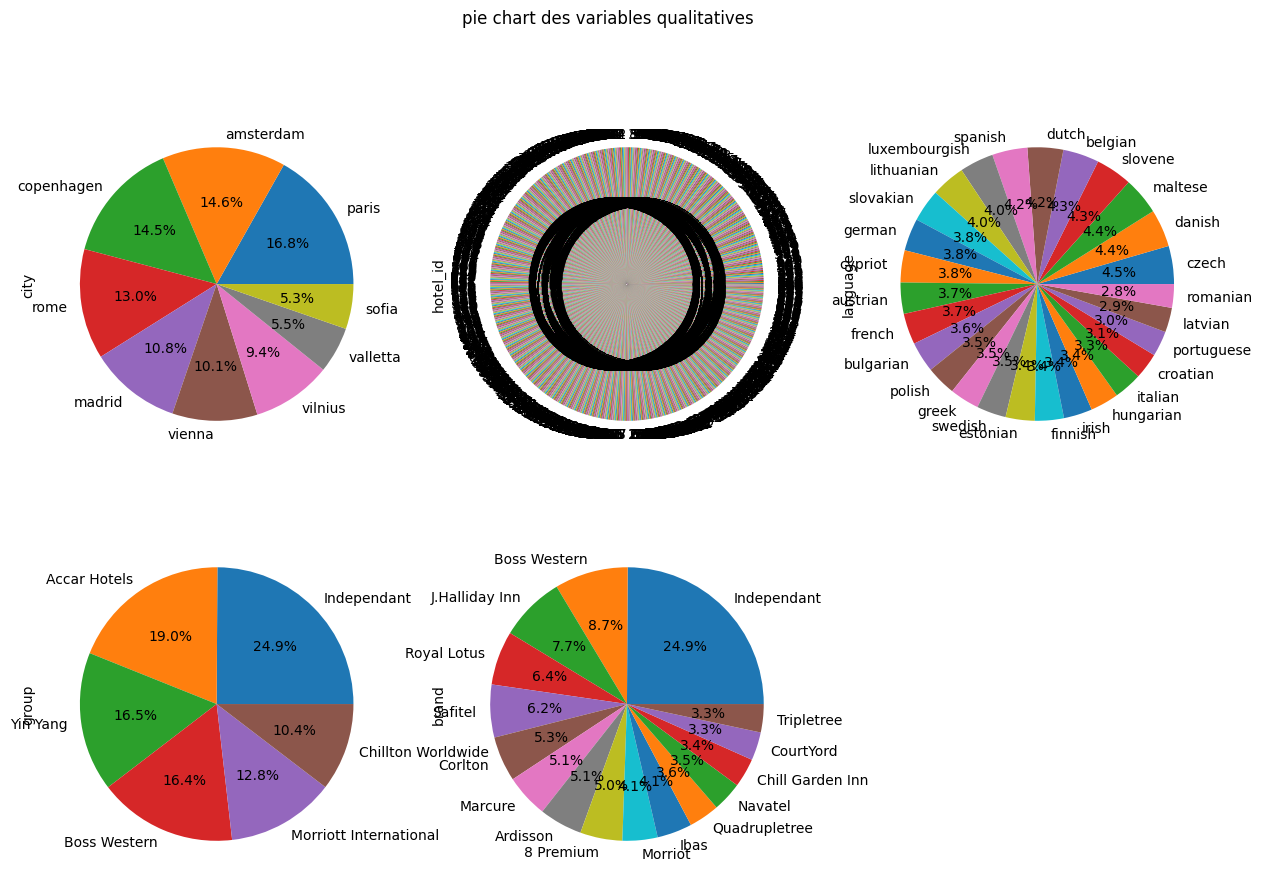

In [43]:
fig = plt.figure(figsize=(15, 10))
i = 1
for var in var_quali_to_encode : 
    plt.subplot(2, 3, i)
    data_mod[var].value_counts().plot.pie(subplots=True, title="pie chart des variables qualitatives", autopct='%1.1f%%')
    i+=1


# Exploration multidimensionnelle

In [60]:
dfY = pd.DataFrame()
dfY["price_mod"]=Y_mod
df_quant = pd.concat([data[["stock_mod","date"]],dfY],axis=1)

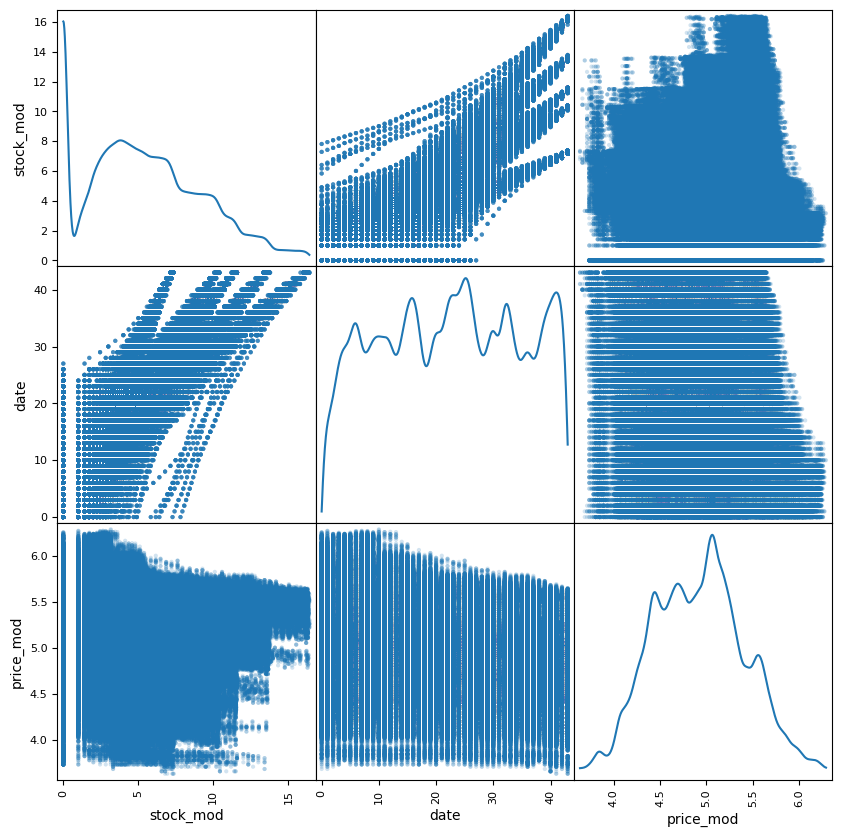

In [61]:
scatter_matrix(df_quant, alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.show()

/home/julie/anaconda3/lib/python3.8/site-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(D, method=method, metric=metric)


<AxesSubplot: >

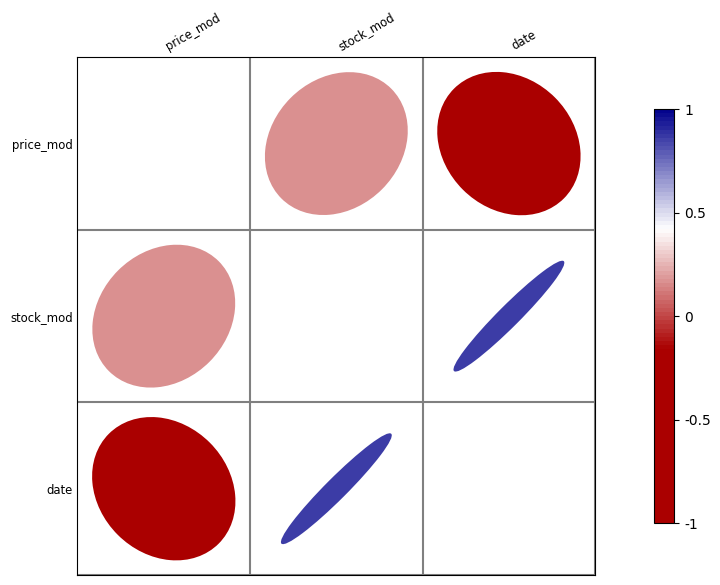

In [62]:
c = Corrplot(df_quant)
c.plot(figsize=(12,6))

Commentaire : 
- On remarque une forte corrélation positive entre le stock et la date (une relation linéaire ?). Cela signifie que les deux variables varie dans le même sens, ce qui est logique car plus la date à laquelle on veut réserver est loin, plus il y a de chances d'avoir beaucoup de places dans l'hôtel et inversement. 
- On remarque une corrélation négative entre la date et le prix, ce qui signifie que les deux variables varient dans des sens opposés. Quand la date de la requête est trèsproche de la date à laquelle on veut réserve, les prix sont plus élevés. 
- Les stocks et la date ne sont pas très corrélées. On a une faible corrélation positive donc cela signifie que quand le nombre de place diminue dans les hôtels, les prix augmentent un peu. Cela coïncide avec notre analyse sur les prix des hôtels plains/avec des places qui suggéraient que les hötels qui ont toujours des places sont 30-40€ plus chers que ceux qui osnt déjà pleins. 